In [6]:
import numpy as np
import pandas as pd

from cv2 import cv2

from matplotlib import pyplot as plt
%matplotlib inline

import skimage as si
import skimage.color
import skimage.transform

import torch
import torchvision
from torch import nn

from tqdm.notebook import tqdm

import os
import requests
import io
from functools import lru_cache


Загружаем данные

In [7]:
imgs = []

directory = 'photo'
files = os.listdir(directory)
for x in files:
    files_dir = directory +'/'+ x
    imgs_dir = os.listdir(files_dir)

    for imgsX in imgs_dir:
        img_dir = files_dir +'/'+ imgsX
        img = cv2.imread(img_dir)
        img = cv2.resize(img, (64, 64))  
        img = skimage.color.rgb2gray(img)
        imgs.append(img)



Image size (64, 64)


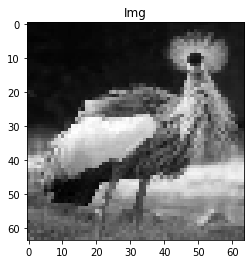

In [8]:
plt.imshow(imgs[10],cmap='gray')
plt.title(f'Img')
print(f'Image size {imgs[10].shape}')


In [9]:
#import cv2 
#cv2.imread()
#описание штуки нужно фотки в чб
#skimage.color.rgb2gray  Computer luminance of an RGB image
#описание штуки
#from skimage.color import rgb2gray
#from skimage import data
#img = data.astronaut()
#img_gray = rgb2gray(img)

Создаем нейроную сеть

In [10]:
from torch.autograd import Variable

class SOM(nn.Module):
  def __init__(self, input_size, out_size=(32, 32), lr=0.3, sigma=None):
    '''
    :param input_size:
    :param out_size:
    :param lr:
    :param sigma:
    '''
    super(SOM, self).__init__()
    self.input_size = input_size
    self.out_size = out_size

    self.lr = lr
    if sigma is None:
      self.sigma = max(out_size) / 2
    else:
      self.sigma = float(sigma)

    self.weight = nn.Parameter(torch.randn(input_size, out_size[0] * out_size[1]), requires_grad=False)
    self.locations = nn.Parameter(torch.Tensor(list(self.get_map_index())), requires_grad=False)
    self.pdist_fn = nn.PairwiseDistance(p=2)
  
  def get_map_index(self):
    '''Two-dimensional mapping function'''
    for x in range(self.out_size[0]):
      for y in range(self.out_size[1]):
        yield (x, y)

  def _neighborhood_fn(self, input, current_sigma):
    ''' e^(-(input / sigma^2))'''
    input.div_(current_sigma ** 2)
    input.neg_()
    input.exp_()

    return input

  def forward (self, input):
    '''
    Find the location of best matching unit.
    :param input: data
    :return: location of best matching unit, loss
    '''
    batch_size = input.size()[0]
    input = input.view(batch_size, -1, 1)
    batch_weight = self.weight.expand(batch_size, -1, -1)

    dists = self.pdist_fn(input, batch_weight)
    #Find best matching unit
    losses, bmu_indexes = dists.min(dim=1, keepdim=True)
    bmu_locations = self.locations[bmu_indexes]

    return bmu_locations, losses.sum().div_(batch_size).item()

  def self_organizing(self, input, current_iter, max_iter):
    '''
    Train the Self Organixing Map (SOM)
    :param input: training data
    :param current_iter: current epoch of total epoch
    :param current_iter: total epoch
    :return: loss (minimum distance)
    '''
    batch_size = input.size()[0]
    #Set learning rate
    iter_correction = 1.0 - current_iter / max_iter
    lr = self.lr * iter_correction
    sigma = self.sigma * iter_correction

    #Find best matching unit
    bmu_locations, loss = self.forward(input)

    distance_squares = self.locations.float() - bmu_locations.float()
    distance_squares.pow_(2)
    distance_squares = torch.sum(distance_squares, dim=2)

    lr_locations = self._neighborhood_fn(distance_squares, sigma)
    lr_locations.mul_(lr).unsqueeze_(1)

    delta = lr_locations * (input.unsqueeze(2) - self.weight)
    delta = delta.sum(dim=0)
    delta.div_(batch_size)
    self.weight.data.add_(delta)

    return loss

Инициализируем датасет

In [11]:
dataset = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.Tensor(imgs)),
    batch_size=32,
    shuffle=True)

Обучаем сеть

In [12]:
imgs[0].shape


(64, 64)

In [13]:
from ipywidgets import widgets
from IPython.display import display
#Интерактивное обучение
niter = 20
m = 2
n = 2
model = SOM(
    input_size=img.shape[0] * img.shape[1] * 1,
    out_size=(m, n, 1), sigma=1)

out = widgets.Output()
out_clusters = widgets.Output()
out_history = widgets.Output()
display(widgets.VBox([out, out_clusters, out_history]))

print("Start train")
X = torch.from_numpy(img)
model.train()
losses = []
for it in tqdm(range(niter), total=niter):
  loss = 0
  n_ = 0
  for (X, ) in dataset:
    loss += model.self_organizing(X.view(X.size()[0], -1), it, niter)
    n_ += 1
  if (it+1) % 5 == 0 or it == 0:
    with out:
      plt.figure()
      buf = model.weight.view(64, 64, -1).argmax(2).float() / 10
      out.clear_output(True)
      plt.imshow(buf, cmap='Accent')
      plt.title(f'{it+1}/{niter} iters (Error: {loss/n_})')
      plt.show()
    
    with out_clusters:
      out_clusters.clear_output(True)
      plt.figure()
      for i in range(m*n):
        plt.subplot(2, 5, i+1)
        plt.imshow(model.weight.view(64, 64, -1)[..., i])
      plt.show()

  with out_history:
    out_history.clear_output(True)
    plt.figure(figsize=(10, 3))
    plt.plot(list(range(len(losses))), (losses), 'b-')
    plt.scatter(list(range(len(losses))), (losses))
    plt.show()
    
  losses.append(loss / n_)

Start train


Тестируем

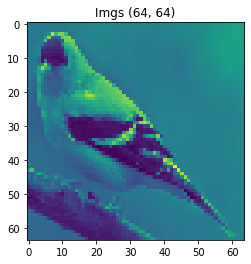

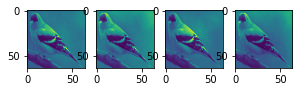

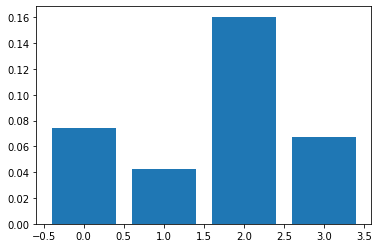

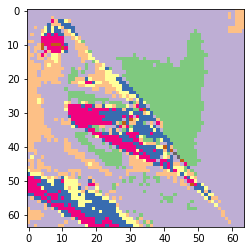

In [14]:
idx = 1101
sample_img = imgs[idx]
sample_label = imgs[idx].shape
plt.figure()
plt.imshow(sample_img)
plt.title(f'Imgs {sample_label}')

plt.figure()
X_ = torch.from_numpy(sample_img).float()
buf = model.weight.view(64, 64, -1).float() * X_.view(64, 64, 1)
buf.div_(buf.max())
for i in range(m*n):
  plt.subplot(2, 5, i+1)
  plt.imshow(buf[..., i])

plt.figure()
#X_sigmoid_()
#buf.sigmoid_()
plt.bar(np.arange(0, m*n, 1), (X_.view(64, 64, 1) - buf.view(64, 64, -1)).abs().permute(2, 0, 1).view(m*n, -1).mean(1))

plt.figure()
buf2 = model.pdist_fn(X_.view(-1, 1), model.weight)
plt.imshow(buf2.view(64, 64), cmap='Accent')